In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import seaborn as sns

In [ ]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator and Noise

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8), # (m, hidden_dim * 8, 3, 3)
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4), # (m, hidden_dim * 4, 7, 7)
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2), # (m, hidden_dim * 2, 15, 15)
            self.make_gen_block(hidden_dim * 2, hidden_dim), # (m, hidden_dim, 31, 31)
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True), # (m, hidden_dim, 64, 64)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )

        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)  # (m, z_dim, 1, 1)
        return self.gen(x) # (m, hidden_dim, 64, 64)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    '''
    return torch.randn(n_samples, z_dim, device=device) # (m, z_dim)

In [ ]:
gen = Generator()
num_test = 100
hidden_dim = 64

test_hidden_noise = get_noise(num_test, gen.z_dim)
x = test_hidden_noise.view(len(test_hidden_noise), gen.z_dim, 1, 1)
print(x.shape)

test_hidden_block = gen.make_gen_block(10, hidden_dim * 8, kernel_size=3, stride=2)
hidden_output = test_hidden_block(x)
print(hidden_output.shape)

test_hidden_block = gen.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=3, stride=2)
hidden_output = test_hidden_block(hidden_output)
print(hidden_output.shape)

test_hidden_block = gen.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=3, stride=2)
hidden_output = test_hidden_block(hidden_output)
print(hidden_output.shape)

test_hidden_block = gen.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2)
hidden_output = test_hidden_block(hidden_output)
print(hidden_output.shape)

test_hidden_block = gen.make_gen_block(hidden_dim, 3, kernel_size=4, stride=2, final_layer=True)
hidden_output = test_hidden_block(hidden_output)
print(hidden_output.shape)

torch.Size([100, 10, 1, 1])
torch.Size([100, 512, 3, 3])
torch.Size([100, 256, 7, 7])
torch.Size([100, 128, 15, 15])
torch.Size([100, 64, 31, 31])
torch.Size([100, 3, 64, 64])


# Classifier

In [ ]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim), # (m, hidden_dim, 31, 31)
            self.make_classifier_block(hidden_dim, hidden_dim * 2), # (m, hidden_dim * 2, 14, 14)
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3), # (m, hidden_dim * 4, 4, 4)
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True), # (m, n_classes, 1, 1)
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor
        '''
        class_pred = self.classifier(image) # (100, num_classes, 1, 1)
        return class_pred.view(len(class_pred), -1) # (100, num_classes)

In [ ]:
disc = Classifier()
hidden_dim = 64

block = disc.make_classifier_block(3, hidden_dim, kernel_size=4, stride=2)
output = block(hidden_output)
print(output.shape)

block = disc.make_classifier_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2)
output = block(output)
print(output.shape)

block = disc.make_classifier_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=3)
output = block(output)
print(output.shape)

block = disc.make_classifier_block(hidden_dim * 4, 2, kernel_size=4, stride=2, final_layer=True)
output = block(output)
print(output.shape)

print(output.view(len(output), -1).shape)

torch.Size([100, 64, 31, 31])
torch.Size([100, 128, 14, 14])
torch.Size([100, 256, 4, 4])
torch.Size([100, 2, 1, 1])
torch.Size([100, 2])


# Model Training

In [ ]:
z_dim = 64
batch_size = 128
device = 'cuda'

n_epochs = 3
display_step = 500
lr = 0.001
beta_1 = 0.5
beta_2 = 0.999
image_size = 64

In [ ]:
label_indices = range(40)

transform = transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

dataloader = DataLoader(
    CelebA("./data", split='train', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
classifier = Classifier(n_classes=len(label_indices)).to(device)
class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

cur_step = 0
classifier_losses = []

In [ ]:
# only for classifier, different from generator and discriminator
filename = 'sample'
for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, f'./models/{filename}')
            cur_step += 1

# Pre-trained Model

In [ ]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/content/gdrive/MyDrive/Colab Notebooks/16 - GANs/models/pretrained_celeba.pth", 
                      map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("/content/gdrive/MyDrive/Colab Notebooks/16 - GANs/models/pretrained_classifier.pth", 
                        map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

# Controlling

## Update Noise

In [ ]:
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
        so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    new_noise = noise + (noise.grad * weight)
    return new_noise

In [ ]:
# Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_() # (m, 64)
fake = gen(noise) # (m, 3, 64, 64)
# only update the first vector
fake_classes = classifier(fake)[:, 0] # (m, 40) --> (m)
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]

## Generation
Now, you can use the classifier along with stochastic gradient ascent to make noise that generates more of a certain feature. In the code given to you here, you can generate smiling faces. Feel free to change the target index and control some of the other features in the list! You will notice that some features are easier to detect and control than others.

The list you have here are the features labeled in CelebA, which you used to train your classifier. If you wanted to control another feature, you would need to get data that is labeled with that feature and train a classifier on that feature.

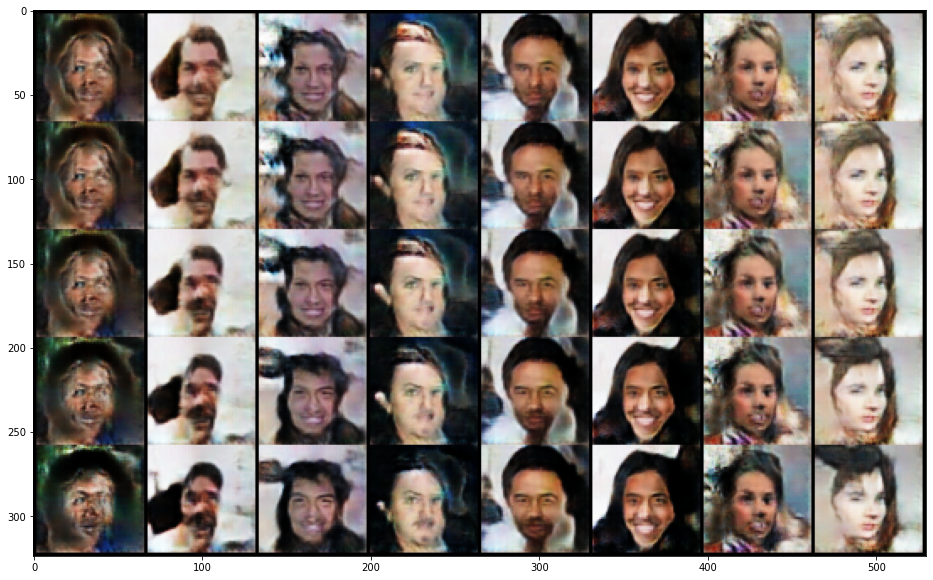

In [ ]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

# Feel free to change this value to any string from feature_names!
target_indices = feature_names.index("BlackHair") 

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## Entanglement and Regularization
You may also notice that sometimes more features than just the target feature change. This is because some features are entangled. To fix this, you can try to isolate the target feature more by holding the classes outside of the target class constant. One way you can implement this is by penalizing the differences from the original class with L2 regularization. This L2 regularization would apply a penalty for this difference using the L2 norm and this would just be an additional term on the loss function.

Here, you'll have to implement the score function: the higher, the better. The score is calculated by adding the target score and a penalty -- note that the penalty is meant to lower the score, so it should have a negative value.

For every non-target class, take the difference between the current noise and the old noise. The greater this value is, the more features outside the target have changed. You will calculate the magnitude of the change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise.

In [ ]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''

    # Calculate the change between the original and current classifications
    other_distances = current_classifications[:, other_indices] - original_classifications[:,other_indices]

    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight

    # Take the mean of the current classifications for the target feature
    target_score = current_classifications[:, target_indices].mean()

    return target_score + other_class_penalty

In [ ]:
 get_score(current_class, original_class, [1, 3] , [0, 2], 0.2).item()

In the following block of code, you will run the gradient ascent with this new score function. You might notice a few things after running it: 

1.   It may fail more often at producing the target feature when compared to the original approach. This suggests that the model may not be able to generate an image that has the target feature without changing the other features. This makes sense! For example, it may not be able to generate a face that's smiling but whose mouth is NOT slightly open. This may also expose a limitation of the generator. 
Alternatively, even if the generator can produce an image with the intended features, it might require many intermediate changes to get there and may get stuck in a local minimum.

2.   This process may change features which the classifier was not trained to recognize since there is no way to penalize them with this method. Whether it's possible to train models to avoid changing unsupervised features is an open question.

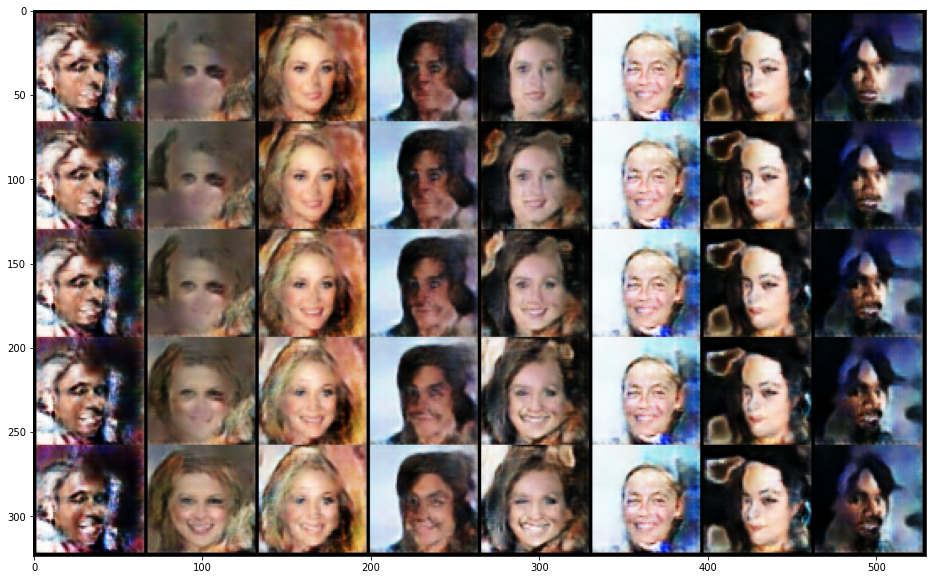

In [ ]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)